# 생물정보학 및 실습 1 - Term Project용 Mission 2 환경 셋업

```
생물정보학 및 실습 1
서울대학교 생물정보학전공/생명과학부 2025년 1학기

이 노트북은 Creative Commons BY-SA 조건으로 재사용 가능합니다.
장혜식 <hyeshik@snu.ac.kr>, 서울대학교 생명과학부
```

이 노트북은 Google Colab을 이용해서 Term Project를 할 수 있도록 환경을 준비해 줍니다. 터미널 사용이 원활하지 않은 상태이고, 데이터를 오랫동안 보관하기 어렵기 때문에 되도록 개인용 컴퓨터에서 [Anaconda](https://www.anaconda.com/)나 [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) 등을 설치하고 사용하시는 것이 편하지만, 개인용 컴퓨터 사양이 부족한 경우에는 Google CoLab을 사용할 수도 있습니다. 개인용 컴퓨터를 쓸 때는 Windows에서는 [WSL2](https://docs.microsoft.com/en-us/windows/wsl/install-win10)를 쓰시면 리눅스 커맨드라인 환경을 쓸 수 있습니다. Google Colab은 창을 닫은 후 90분 후, 또는 창을 처음 열고 12시간 후에 환경을 닫아버리기 때문에 매번 실습할 때마다 새로 셋업이 필요합니다. `Runtime->Run All`을 실행해서 전체를 한 번 실행하시면 준비됩니다. 모든 것이 잘 안 되고 뭔가 꼬인 느낌이 강하게 들 때는 `Runtime->Factory reset runtime`을 누르고 새로 시작하시면 될 수도 있습니다.


# 프로그램 설치

**첫 실습 시간에 데이터 복사를 마쳤으면 여기부터 시작합니다.**

데이터 준비가 끝났으면, 이제 이번 시간 실습에 필요한 프로그램들 몇 가지를 추가로 설치합니다.

In [ ]:
!conda install -y bedtools bioawk samtools
# samtools는 제대로 설치되지 않음, PATH에 /blaze/apps/envs/samtools/bin 추가하는 것으로 해결

## Mission 2

이번 미션에서는 start codon 주변에서 ribosome-protected fragment의 분포를 한 번 살펴보겠습니다. 보통은 RPF의 5'-end 분포가 start codon 앞 15nt 정도에서부터 본격적으로 많이 나오고, 거기서부터 CDS를 걸쳐서 3nt 주기로 올록볼록한 패턴이 나타납니다.

이 그림을 제대로 그리려면 genome coordinate를 start codon을 기준으로 변환해서 작업해야 하지만, 이번 미션에서는 난이도를 적절히 내리기 위해서 start codon이 포함된 exon에 존재하는 5' end만 추려서 작업하도록 합시다. (여유가 좀 있어서 난이도를 적당히 올리고 싶은 분들은 negative strand를 포함할 수도 있고, start codon과 다른 exon에 있는 경우를 포함할 수도 있습니다. 또한 APPRIS 등을 기반으로 해서 transcript 중에 가장 )

In [3]:
# %cd /content/drive/MyDrive/binfo1-work/
%cd binfo1-mission2

/qbio/mahoon2/bioinfo1/binfo1-mission2


우선 annotation에서 start codon이 포함된 exon만 추립니다. Gene 한 개에 isoform이 여러 개 있는 경우 모두 쓰면 read가 너무 부풀려질 수 있기 때문에 우선 transcript support level이 1인 것만 추려서 사용합니다. 여전히 TSL 1만 쓰더라도 부풀려질 가능성은 있기 때문에 제대로 하자면 APPRIS나 RNA-seq 데이터 기준으로 하나만 선정하는 것이 좋습니다만, 일단 여기서는 간단히..

그리고, - strand가 들어가면 좀 계산이 복잡해지니까 또 간단하게 하기 위해서 + strand만 고릅니다. 이번엔 일단 무조건 간단하게 해 봅시다~

In [ ]:
!grep '	start_codon	.*	+	.*transcript_support_level "1"' ../binfo1-datapack1/gencode.gtf | \
 sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-start.gtf
!head gencode-start.gtf

chr1	HAVANA	start_codon	4878137	4878139	.	+	0	ENSMUST00000134384.8
chr1	HAVANA	start_codon	4878137	4878139	.	+	0	ENSMUST00000027036.11
chr1	HAVANA	start_codon	4878137	4878139	.	+	0	ENSMUST00000150971.8
chr1	HAVANA	start_codon	4928137	4928139	.	+	0	ENSMUST00000081551.14
chr1	HAVANA	start_codon	5154674	5154676	.	+	0	ENSMUST00000044369.13
chr1	HAVANA	start_codon	5659272	5659274	.	+	0	ENSMUST00000160777.8
chr1	HAVANA	start_codon	5659272	5659274	.	+	0	ENSMUST00000027038.11
chr1	HAVANA	start_codon	6300227	6300229	.	+	0	ENSMUST00000027040.13
chr1	HAVANA	start_codon	6429555	6429557	.	+	0	ENSMUST00000133144.4
chr1	HAVANA	start_codon	6839122	6839124	.	+	0	ENSMUST00000140079.8


start codon가 들어가 있는 exon들을 고르기 위해서 미리 + strand에 있는 exon를 추립니다.. start codon 쪽에서 TSL 기준으로 골랐기 때문에 여기서는 고르지 않아도 됩니다. 물론 좀 느려지기는 하지만...

In [ ]:
# 아래 공백 중 일부는 "탭(Tab)" 문자입니다. 입력하기 힘들 때는 텍스트 편집기에서 입력해서 복사&붙여넣기 하면 됩니다.
!grep '	exon	.*	+	' ../binfo1-datapack1/gencode.gtf | \
 sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-plusexon.gtf
!head gencode-plusexon.gtf

chr1	HAVANA	exon	3143476	3144545	.	+	.	ENSMUST00000193812.2
chr1	ENSEMBL	exon	3172239	3172348	.	+	.	ENSMUST00000082908.3
chr1	HAVANA	exon	3322980	3323459	.	+	.	ENSMUST00000192857.2
chr1	HAVANA	exon	3536810	3536910	.	+	.	ENSMUST00000161581.2
chr1	HAVANA	exon	3583628	3583776	.	+	.	ENSMUST00000161581.2
chr1	HAVANA	exon	3602018	3602943	.	+	.	ENSMUST00000192183.2
chr1	HAVANA	exon	3750378	3752011	.	+	.	ENSMUST00000193244.2
chr1	HAVANA	exon	3822233	3824583	.	+	.	ENSMUST00000194454.2
chr1	HAVANA	exon	4566774	4569601	.	+	.	ENSMUST00000193450.2
chr1	HAVANA	exon	4567697	4567877	.	+	.	ENSMUST00000194935.2


그 다음엔 exon 리스트와 start codon 리스트를 겹치고, transcript가 같은 것만 살려둡니다. 기왕 좀 다루기 쉽도록 출력은 bed로 하면서 좌표계를 바꿉니다. 결과는 bedtools에서 빠르게 다룰 수 있게 sort해 둡니다.

In [4]:
# 아래 공백 중 일부는 "탭(Tab)" 문자입니다. 입력하기 힘들 때는 텍스트 편집기에서 입력해서 복사&붙여넣기 하면 됩니다.
!bedtools intersect -a gencode-start.gtf -b gencode-plusexon.gtf -wa -wb | \
 awk -F'	' -v OFS='	' '$9 == $18 { print $10, $13-1, $14, $18, $4-1, $16; }' | \
 sort -k1,1 -k2,3n -k4,4 > gencode-exons-containing-startcodon.bed
!head gencode-exons-containing-startcodon.bed; tail gencode-exons-containing-startcodon.bed

chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4928036	4928199	ENSMUST00000081551.14	4928136	+
chr1	5154639	5154786	ENSMUST00000044369.13	5154673	+
chr1	5659227	5659528	ENSMUST00000027038.11	5659271	+
chr1	5659257	5659528	ENSMUST00000160777.8	5659271	+
chr1	6300182	6300297	ENSMUST00000027040.13	6300226	+
chr1	6429441	6429738	ENSMUST00000133144.4	6429554	+
chr1	6839121	6839176	ENSMUST00000043578.13	6839121	+
chrY	80939672	80939804	ENSMUST00000185340.2	80939686	+
chrY	81470683	81470815	ENSMUST00000187135.2	81470697	+
chrY	82237903	82238035	ENSMUST00000185636.2	82237917	+
chrY	83043623	83043755	ENSMUST00000187165.2	83043637	+
chrY	84109956	84110088	ENSMUST00000185776.7	84109970	+
chrY	84759361	84759493	ENSMUST00000186110.2	84759375	+
chrY	86074448	86074580	ENSMUST00000188754.2	86074462	+
chrY	87129500	87129632	ENSMUST00000189543.7	87129514	+
chrY	87563647	87563779	ENSMUST0000

컬럼 4번에 transcript id, 5번에 start codon 위치를 넣었는데, start codon이 같은 것들이 여러개 눈에 띕니다. 아주 찝찝하지만, 우선 이번은 간단하게 할 것이기 때문에 눈을 질끈 감고 넘어가 봅시다.

이제 alignment를 준비합니다. + strand alignment에서 read length가 짧은 것도 미리 필터링 합니다. RPF는 보통 25nt 이상이기 때문에 그 이하는 거의 확실히 rRNA, tRNA 등에서 오염된 것들입니다. SAM 파일 전체를 필터링해서 다시 인코딩하기 때문에 시간이 좀 걸립니다.

오래걸리는 작업을 돌릴 떄에는 CPU 사용량, 디스크 사용량을 계속 관찰하는 것이 좋습니다. 직접 접속할 수 있는 컴퓨터에서는 `htop` 등의 명령을 쓰면 되고, Colab에서는 오른쪽 위의 메뉴에서 Resources를 띄우면 되는데, 여기서는 CPU 사용량은 보기 힘듭니다.

In [8]:
!export PATH=/blaze/apps/envs/samtools/1.20/bin:$PATH

In [ ]:
!(/blaze/apps/envs/samtools/1.20/bin/samtools view -H ../binfo1-datapack1/RPF-siLuc.bam; \
  /blaze/apps/envs/samtools/1.20/bin/samtools view -F20 ../binfo1-datapack1/RPF-siLuc.bam | \
  bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | \
 /blaze/apps/envs/samtools/1.20/bin/samtools view -b -o filtered-RPF-siLuc.bam

In [22]:
!(/blaze/apps/envs/samtools/1.20/bin/samtools view -H ../binfo1-datapack1/RPF-siLin28a.bam; \
  /blaze/apps/envs/samtools/1.20/bin/samtools view -F20 ../binfo1-datapack1/RPF-siLin28a.bam | \
  bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | \
 /blaze/apps/envs/samtools/1.20/bin/samtools view -b -o filtered-RPF-siLin28a.bam

^C


큰 일을 했으니 용량을 한 번 봅니다.

In [12]:
!ls -alh *RPF-siLuc.bam

-rw-r--r-- 1 mahoon2 qbio 529M May 12 13:43 filtered-RPF-siLuc.bam


In [23]:
!ls -alh *RPF-siLin28a.bam

-rw-r--r-- 1 mahoon2 qbio 375M May 13 19:19 filtered-RPF-siLin28a.bam


자 이제 read의 5' end 위치를 셉니다. bedtools의 `genomecov`를 쓰면 아주 편리합니다.

In [13]:
!bedtools genomecov -ibam filtered-RPF-siLuc.bam -bg -5 > fivepcounts-RPF-siLuc.bed
!head fivepcounts-RPF-siLuc.bed

chr1	3176534	3176535	1
chr1	3196256	3196257	1
chr1	3221526	3221527	1
chr1	3221542	3221543	2
chr1	3221545	3221546	3
chr1	3221546	3221547	2
chr1	3221548	3221550	1
chr1	3221571	3221572	1
chr1	3221897	3221898	1
chr1	3221994	3221995	1


In [24]:
!bedtools genomecov -ibam filtered-RPF-siLin28a.bam -bg -5 > fivepcounts-RPF-siLin28a.bed
!head fivepcounts-RPF-siLin28a.bed

chr1	3123359	3123360	1
chr1	3124284	3124285	1
chr1	3188296	3188297	1
chr1	3221546	3221547	1
chr1	3221549	3221550	2
chr1	3221868	3221869	1
chr1	3222153	3222154	1
chr1	3222413	3222415	1
chr1	3222638	3222639	1
chr1	3224556	3224557	1


그렇게 match 된 것들 중에 앞에서 찾은 start codon을 포함한 exon과 겹치는 것만 골라냅니다.

In [ ]:
!bedtools intersect -a fivepcounts-RPF-siLuc.bed -b gencode-exons-containing-startcodon.bed \
 -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLuc.txt
!head fivepcounts-filtered-RPF-siLuc.txt

chr1	4878048	4878049	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878048	4878049	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878077	4878078	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878077	4878078	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878077	4878078	1	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878101	4878102	4	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878101	4878102	4	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878101	4878102	4	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878103	4878104	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878103	4878104	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+


In [25]:
!bedtools intersect -a fivepcounts-RPF-siLin28a.bed -b gencode-exons-containing-startcodon.bed \
 -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLin28a.txt
!head fivepcounts-filtered-RPF-siLin28a.txt

chr1	4878043	4878044	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878056	4878057	3	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878056	4878057	3	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878056	4878057	3	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878074	4878075	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878074	4878075	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878074	4878075	1	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878089	4878090	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878089	4878090	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878089	4878090	1	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+


모든 준비가 끝났습니다. 이제 Figure S5A 도전해 보세요!

* stop codon은 빼고 start codon 만입니다.
* 논문에서는 처리가 어려운 부분까지 모두 포함됐고, read를 중첩해서 세지 않았기 때문에, 여기서 세는 것과는 수치는 다를 수 있습니다.
* `pandas`로 한꺼번에 데이터를 모두 불러들이면 메모리가 부족할 수도 있습니다. 그런 경우에는 chunk를 쓰거나, 줄 단위로 처리해 보세요.

In [ ]:
# 여기에 새로 코드를 작성해서 논문 그림과 비슷하게 만들어 봅시다.

In [1]:
# %cd /content/drive/MyDrive/binfo1-work/
%cd binfo1-mission2

/qbio/mahoon2/bioinfo1/binfo1-mission2


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

siluc = pd.read_csv('fivepcounts-filtered-RPF-siLuc.txt', sep='\t', header=None)
siluc.columns = ['chrom_read', '5_start', '5_end', '5_cnt',
                 'chrom_annot', 'exon_start', 'exon_end', 'transcript_id', 'start_codon_pos', 'strand']
siluc.head()

,chrom_read,5_start,5_end,5_cnt,chrom_annot,exon_start,exon_end,transcript_id,start_codon_pos,strand
0,chr1,4878048,4878049,1,chr1,4878010,4878205,ENSMUST00000134384.8,4878136,+
1,chr1,4878048,4878049,1,chr1,4878045,4878205,ENSMUST00000027036.11,4878136,+
2,chr1,4878077,4878078,1,chr1,4878010,4878205,ENSMUST00000134384.8,4878136,+
3,chr1,4878077,4878078,1,chr1,4878045,4878205,ENSMUST00000027036.11,4878136,+
4,chr1,4878077,4878078,1,chr1,4878052,4878205,ENSMUST00000150971.8,4878136,+


In [3]:
siluc['5_cnt'].describe()

count    340499.000000
mean          4.590665
std          33.162029
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        8089.000000
Name: 5_cnt, dtype: float64

In [4]:
siluc['relative_pos'] = siluc['5_start'] - siluc['start_codon_pos']
siluc['relative_pos'].describe()

count    340499.000000
mean        161.919962
std         544.218402
min       -7536.000000
25%         -14.000000
50%          37.000000
75%         174.000000
max        6890.000000
Name: relative_pos, dtype: float64

In [5]:
siluc_counts = siluc[(siluc['relative_pos'] > -51) & (siluc['relative_pos'] < 51)].groupby('relative_pos')['5_cnt'].sum()
siluc_counts

relative_pos
-50    2878
-49    2556
-48    2366
-47    3442
-46    2656
       ... 
 46    1077
 47    4401
 48    4608
 49     777
 50    3760
Name: 5_cnt, Length: 101, dtype: int64

In [6]:
import matplotlib as mpl
mpl.font_manager.findSystemFonts()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']

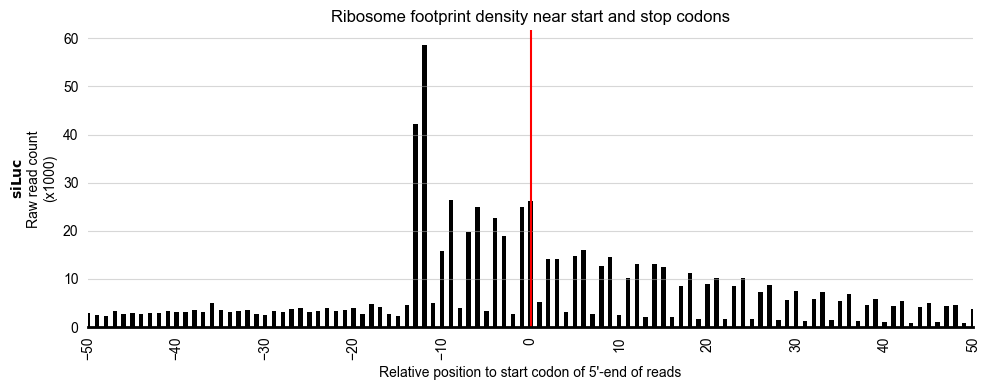

In [7]:
fig = plt.figure(figsize=(10,4))
plt.bar(siluc_counts.index, siluc_counts.values / 1000, color='black', width=0.5)
plt.grid(axis='y', alpha=0.5)

plt.xlim(-50, 50)
plt.axvline(0, color='red', linestyle='-')

plt.xlabel('Relative position to start codon of 5\'-end of reads')
plt.ylabel(r'$\mathbf{siLuc}$' + '\n' + 'Raw read count\n(x1000)')

plt.xticks(np.arange(-50, 51, 10), rotation=90)
fig.get_axes()[0].tick_params(
    axis='both',      # 'x','y' 또는 'both'
    which='both',     # 'major','minor','both'
    bottom=False,     # x축 아래쪽 tick
    top=False,        # x축 위쪽 tick
    left=False,       # y축 왼쪽 tick
    right=False       # y축 오른쪽 tick
)

for name, spine in fig.get_axes()[0].spines.items():
    if name != 'bottom':
        spine.set_visible(False)
    else:
        spine.set_linewidth(2.0)

plt.title('Ribosome footprint density near start and stop codons')
plt.tight_layout()
plt.show()

In [8]:
silin28a = pd.read_csv('fivepcounts-filtered-RPF-siLin28a.txt', sep='\t', header=None)
silin28a.columns = ['chrom_read', '5_start', '5_end', '5_cnt',
                 'chrom_annot', 'exon_start', 'exon_end', 'transcript_id', 'start_codon_pos', 'strand']
silin28a.head()

,chrom_read,5_start,5_end,5_cnt,chrom_annot,exon_start,exon_end,transcript_id,start_codon_pos,strand
0,chr1,4878043,4878044,1,chr1,4878010,4878205,ENSMUST00000134384.8,4878136,+
1,chr1,4878056,4878057,3,chr1,4878010,4878205,ENSMUST00000134384.8,4878136,+
2,chr1,4878056,4878057,3,chr1,4878045,4878205,ENSMUST00000027036.11,4878136,+
3,chr1,4878056,4878057,3,chr1,4878052,4878205,ENSMUST00000150971.8,4878136,+
4,chr1,4878074,4878075,1,chr1,4878010,4878205,ENSMUST00000134384.8,4878136,+


In [9]:
silin28a['relative_pos'] = silin28a['5_start'] - silin28a['start_codon_pos']

In [10]:
silin28a_counts = silin28a[(silin28a['relative_pos'] > -51) & (silin28a['relative_pos'] < 51)].groupby('relative_pos')['5_cnt'].sum()
silin28a_counts

relative_pos
-50    1799
-49    1714
-48    1464
-47    2410
-46    1740
       ... 
 46     779
 47    2845
 48    3331
 49     562
 50    2425
Name: 5_cnt, Length: 101, dtype: int64

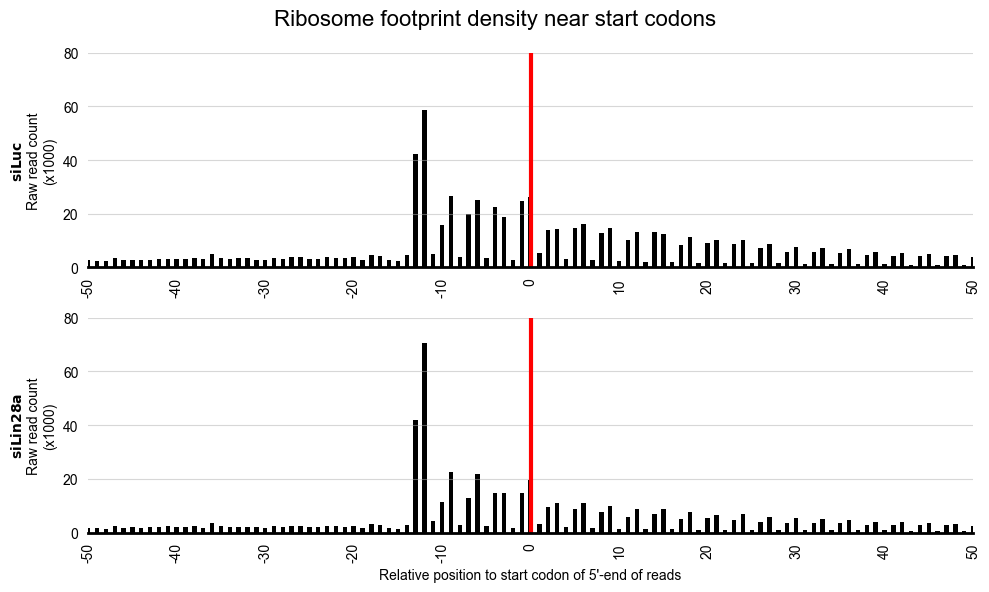

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

axes[0].axvline(0, color='red', linestyle='-', linewidth=3)
axes[0].bar(siluc_counts.index, siluc_counts.values / 1000, color='black', width=0.5)
axes[0].grid(axis='y', alpha=0.5)

axes[0].set_xlim(-50, 50)
axes[0].set_ylim(0, 80)

axes[0].set_ylabel(r'$\mathbf{siLuc}$' + '\n' + 'Raw read count\n(x1000)')

axes[0].set_xticks(ticks=np.arange(-50, 51, 10), labels=list(map(str, np.arange(-50, 51, 10))), rotation='vertical')
axes[0].tick_params(
    axis='both',      # 'x','y' 또는 'both'
    which='both',     # 'major','minor','both'
    bottom=False,     # x축 아래쪽 tick
    top=False,        # x축 위쪽 tick
    left=False,       # y축 왼쪽 tick
    right=False       # y축 오른쪽 tick
)

for name, spine in axes[0].spines.items():
    if name != 'bottom':
        spine.set_visible(False)
    else:
        spine.set_linewidth(2.0)

axes[1].axvline(0, color='red', linestyle='-', linewidth=3)
axes[1].bar(silin28a_counts.index, silin28a_counts.values / 1000, color='black', width=0.5)
axes[1].grid(axis='y', alpha=0.5)

axes[1].set_xlim(-50, 50)
axes[1].set_ylim(0, 80)

axes[1].set_xlabel('Relative position to start codon of 5\'-end of reads')
axes[1].set_ylabel(r'$\mathbf{siLin28a}$' + '\n' + 'Raw read count\n(x1000)')

axes[1].set_xticks(ticks=np.arange(-50, 51, 10), labels=list(map(str, np.arange(-50, 51, 10))), rotation='vertical')
axes[1].tick_params(
    axis='both',      # 'x','y' 또는 'both'
    which='both',     # 'major','minor','both'
    bottom=False,     # x축 아래쪽 tick
    top=False,        # x축 위쪽 tick
    left=False,       # y축 왼쪽 tick
    right=False       # y축 오른쪽 tick
)

for name, spine in axes[1].spines.items():
    if name != 'bottom':
        spine.set_visible(False)
    else:
        spine.set_linewidth(2.0)

fig.suptitle('Ribosome footprint density near start codons', fontsize=16)
plt.tight_layout()
plt.show()